In [1]:
import math
import torch
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import tmap as tm
from faerun import Faerun
from tqdm import tqdm
tqdm.pandas()
from pathlib import Path
# from annoy import AnnoyIndex
import pynndescent
import rdkit.Chem as Chem
from pandarallel import pandarallel
from scipy.spatial.distance import cosine as cosine_distance
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.colors import ListedColormap
import msml.utils.spectra as su
import msml.utils.data as du
import msml.utils.mols as mu
from msml.utils.plots import init_plotting, save_fig, get_nature_hex_colors
from msml.utils.lcms import *
init_plotting()
from msml.definitions import *
%reload_ext autoreload
%autoreload 2

In [2]:
version = 2
cos_sim = su.PeakListModifiedCosine()
mol_calc = mu.MolPropertyCalculator()
palette = get_nature_hex_colors() + ['#FEA992', '#AB8D8B', '#A8A9AB']  # TODO: move to get_nature_hex_colors
out_dir = Path('/storage/brno2/home/romanb/msml/msml/data/dreams_atlas')

# Data loading

### Load spectral library

In [3]:
df_lib = pd.read_pickle(MERGED_DATASETS / 'nist20_mona_clean_A_merged_spectra_dreams.pkl')
df_lib_props = df_lib['ROMol'].progress_apply(mol_calc.mol_to_props)
df_lib = pd.concat([df_lib, pd.DataFrame(df_lib_props.tolist()).set_index(df_lib.index)], axis=1)
df_lib

100%|██████████| 72759/72759 [03:44<00:00, 324.17it/s]


,ID,PARSED PEAKS,PRECURSOR M/Z,PRECURSOR TYPE,SMILES,FORMULA,inchi14,ROMol,DreaMS,AtomicLogP,NumHAcceptors,NumHDonors,PolarSurfaceArea,NumRotatableBonds,NumAromaticRings,NumAliphaticRings,FractionCSP3,QED,SyntheticAccessibility,BertzComplexity
0,[MoNA_84124_Scopolamine hydrobromide],"[[45.350388, 61.961365, 82.289032, 94.064453, ...",304.154000,[M+H]+,Br.CN1[C@@H]2C[C@@H](OC(=O)[C@H](CO)c3ccccc3)C...,C17H22BrNO4,WTGQALLALWYDJH,<rdkit.Chem.rdchem.Mol object at 0x7f26b10ea8b0>,"[0.07978646457195282, -1.3950639963150024, -0....",1.4960,5,1,62.30,4,1,3,0.588235,0.629883,4.832235,550.971612
1,"[MoNA_6394_ARECOLINE HYDROBROMIDE, MoNA_6395_A...","[[50.034736, 50.571855, 50.68663, 50.889288, 5...",236.028061,[M+H]+,Br.COC(=O)C1=CCCN(C)C1,C8H14BrNO2,AXOJRQLKMVSHHZ,<rdkit.Chem.rdchem.Mol object at 0x7f26b10ea860>,"[-0.5999295711517334, -0.2546186149120331, -0....",0.9992,3,0,29.54,1,0,1,0.625000,0.635899,2.787156,191.496882
2,"[MoNA_6388_ARECOLINE HYDROBROMIDE, MoNA_6389_A...","[[50.004952, 50.664683, 51.940288, 52.441631, ...",273.983948,[M+K]+,Br.COC(=O)C1=CCCN(C)C1,C8H14BrNO2,AXOJRQLKMVSHHZ,<rdkit.Chem.rdchem.Mol object at 0x7f26b10ea950>,"[-0.6357250213623047, -0.3518996238708496, -0....",0.9992,3,0,29.54,1,0,1,0.625000,0.635899,2.787156,191.496882
3,"[MoNA_6385_ARECOLINE HYDROBROMIDE, MoNA_6386_A...","[[50.625048, 51.227528, 51.287, 51.364814, 51....",253.054611,[M+NH4]+,Br.COC(=O)C1=CCCN(C)C1,C8H14BrNO2,AXOJRQLKMVSHHZ,<rdkit.Chem.rdchem.Mol object at 0x7f26b10ea9a0>,"[-0.4656747281551361, -0.47065573930740356, 0....",0.9992,3,0,29.54,1,0,1,0.625000,0.635899,2.787156,191.496882
4,"[MoNA_6391_ARECOLINE HYDROBROMIDE, MoNA_6392_A...","[[51.940221, 52.940355, 53.038909, 54.986084, ...",258.010010,[M+Na]+,Br.COC(=O)C1=CCCN(C)C1,C8H14BrNO2,AXOJRQLKMVSHHZ,<rdkit.Chem.rdchem.Mol object at 0x7f26b10ea9f0>,"[-0.2894027829170227, 0.3301682770252228, 0.87...",0.9992,3,0,29.54,1,0,1,0.625000,0.635899,2.787156,191.496882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72754,"[NIST20_3049389, NIST20_3049390, NIST20_3049391]","[[52.0179, 54.0335, 55.0288, 55.0415, 56.0366,...",137.082200,[M+H]+,c1ncc2c(n1)NCCN2,C6H8N4,IDAICLIJTRXNER,<rdkit.Chem.rdchem.Mol object at 0x7f25f90489a0>,"[-2.0403926372528076, 1.0690866708755493, 0.34...",0.3140,4,2,49.84,0,1,1,0.333333,0.538744,3.247512,209.944355
72755,"[NIST20_1063725, NIST20_1063726, NIST20_106372...","[[37.9976, 39.9, 40.02, 40.0407, 40.0578, 40.0...",121.050900,[M+H]+,c1ncc2nc[nH]c2n1,C5H4N4,KDCGOANMDULRCW,<rdkit.Chem.rdchem.Mol object at 0x7f25f90489f0>,"[-0.8900308012962341, 0.6306561827659607, -0.7...",0.3529,3,1,54.46,0,2,0,0.000000,0.545467,2.907382,282.935781
72756,"[NIST20_1561546, NIST20_1561547, NIST20_156154...","[[53.0384, 55.054, 65.0384, 77.0384, 79.054, 8...",369.159900,[M+H-C2H3N3]+,c1ncn([Sn](C2CCCCC2)(C2CCCCC2)C2CCCCC2)n1,C20H35N3Sn,ONHBDDJJTDTLIR,<rdkit.Chem.rdchem.Mol object at 0x7f25f9048a40>,"[-1.6180341243743896, 1.2312947511672974, 0.45...",6.0746,3,0,30.71,4,1,3,0.900000,0.536477,3.531714,437.443181
72757,"[NIST20_1561564, NIST20_1561565, NIST20_156156...","[[53.0384, 55.054, 55.9342, 65.0383, 77.0383, ...",287.081600,[M+H-C8H13N3]+,c1ncn([Sn](C2CCCCC2)(C2CCCCC2)C2CCCCC2)n1,C20H35N3Sn,ONHBDDJJTDTLIR,<rdkit.Chem.rdchem.Mol object at 0x7f25f9048a90>,"[-0.5446420907974243, 0.28371235728263855, 0.8...",6.0746,3,0,30.71,4,1,3,0.900000,0.536477,3.531714,437.443181


### Load GeMS

In [4]:
gems_pth = '/auto/plzen1/home/romanb/msvn_A/msvn_A_H1000_K1_N2000000.hdf5'
f = h5py.File(gems_pth, 'r')
names_gems = pd.Series(f['name'][:]).str.decode('utf-8')

# Select the subset of 1M indices of non-blank spectra (spectra are already shuffled)
blank_substrs = ['blank', 'wash', 'no_inj', 'noinj', 'empty', 'solvent']
names_gems = names_gems[names_gems.progress_apply(lambda n: all([s not in n.lower() for s in blank_substrs]))]
idx_gems = names_gems.index.tolist()
idx_gems = idx_gems[:1_000_000]

# Load data for the selected subset
names_gems = pd.Series(f['name'][:][idx_gems]).str.decode('utf-8')
prec_mzs_gems = f['precursor mz'][:][idx_gems]
lshs_gems = f['lsh'][:][idx_gems]
def spec_gems(i):  # Do not load all spectra in RAM
    return f['spectra'][idx_gems[i]].T
embs_gems = torch.load('/auto/plzen1/home/romanb/msvn_A/msvn_A_H1000_K1_N2000000_dreams_embs.pt', map_location=torch.device('cpu')).numpy()
embs_gems = embs_gems[:][idx_gems]
embs_gems.shape

100%|██████████| 2000000/2000000 [00:03<00:00, 577558.18it/s]


(1000000, 1024)

### Load GeMS metadata from MassIVE

In [5]:
df_msv = pd.read_csv(MASSIVE_DIR / 'data/N_A_filtered_results.tsv', sep='\t', comment='#')
df_msv['species_resolved'] = standartize_species(df_msv['species_resolved'])
df_msv = df_msv.set_index('dataset')
df_msv.head()

/tmp/ipykernel_272880/3317512780.py:1: DtypeWarning: Columns (30,57,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df_msv = pd.read_csv(MASSIVE_DIR / 'data/N_A_filtered_results.tsv', sep='\t', comment='#')


,task,user_id,create_time,begin_time,end_time,now,status,messages,title,flowname,...,quant_analysis,realname,user,pis,publication_list,container_list,reanalyses,quant_reanalyses,hash,px
dataset,,,,,,,,,,,,,,,,,,,,,
MSV000093891,ccd7e749ea6e41848c074f713443a8e6,xiaoxie,2024-01-18 22:58:45.0,2024-01-18 22:58:46.0,2024-01-18 23:11:18.0,2024-01-20 08:01:25.0,DONE,NaN,Oxidative Cyclization Reagents Reveal Tryptoph...,MASSIVE-COMPLETE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MSV000093885,2e210c381c65403cb2bacefb42901426,oloap1,2024-01-18 05:11:39.0,2024-01-18 05:11:43.0,2024-01-18 05:21:07.0,2024-01-20 08:01:25.0,DONE,NaN,Test SynCom strains interaction 211223,MASSIVE-COMPLETE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MSV000093884,19ea6d98d9964f9b831af1012401d762,mbhulst,2024-01-18 00:07:40.0,2024-01-18 00:07:41.0,2024-01-18 00:12:06.0,2024-01-20 08:01:25.0,DONE,NaN,Metabolic engineering of Streptomyces peucetiu...,MASSIVE-COMPLETE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MSV000093875,586329aeff2745deb52750093c296b35,zhengzhang,2024-01-16 09:48:37.0,2024-01-16 09:48:38.0,2024-01-16 09:53:41.0,2024-01-20 08:01:25.0,DONE,NaN,An XIC-centric approach for improved identific...,MASSIVE-COMPLETE,...,NaN,Zheng Zhang,Zheng Zhang (zhengzhang),Guanghui Wang;guanghui.wang@nist.gov;NIST;USA,NaN,NaN,NaN,NaN,NaN,NaN
MSV000093872,6c85395e512540a1b0bf2822c6c6478d,JacobAgerbo,2024-01-16 03:47:27.0,2024-01-16 03:47:48.0,2024-01-16 03:59:39.0,2024-01-20 08:01:25.0,DONE,NaN,HoloFish - Untargeted Metabolomics,MASSIVE-COMPLETE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Combine everything needed for the atlas except for spectra and embeddings into a single dataframe

In [6]:
df = pd.DataFrame({
    'DATASET': ['MoNA and NIST20'] * len(df_lib) + ['GeMS'] * embs_gems.shape[0],
    'SMILES': df_lib['SMILES'].tolist() + ['H'] * embs_gems.shape[0],
    'FORMULA': df_lib['FORMULA'].tolist() + [''] * embs_gems.shape[0],
    'NAME': df_lib.index.tolist() + names_gems.tolist(),
    'PRECURSOR M/Z': df_lib['PRECURSOR M/Z'].tolist() + prec_mzs_gems.tolist(),
    'MSV ID': [''] * len(df_lib) + names_gems.apply(lambda x: x.split('_')[0]).tolist(),
    'FILE NAME': [''] * len(df_lib) + names_gems.apply(lambda x: '_'.join(x.split('_')[1:])).tolist(),
})
pandarallel.initialize(progress_bar=True, nb_workers=4, use_memory_fs=False)
df['MSV ID number'] = df['MSV ID'].apply(lambda m: int(m[len('MSV'):]) if m else None)
df['SPECIES'] = df['MSV ID'].parallel_apply(lambda m: df_msv.loc[m]['species_resolved'] if m else '')
df['INSTRUMENT'] = df['MSV ID'].parallel_apply(lambda m: df_msv.loc[m]['instrument_resolved'] if m else '')
df['FORMULA TYPE'] = df['FORMULA'].progress_apply(lambda f: mu.formula_type(mu.formula_to_dict(f)))
df

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


100%|██████████| 1072759/1072759 [00:03<00:00, 297199.24it/s]


,DATASET,SMILES,FORMULA,NAME,PRECURSOR M/Z,MSV ID,FILE NAME,MSV ID number,SPECIES,INSTRUMENT,FORMULA TYPE
0,MoNA and NIST20,Br.CN1[C@@H]2C[C@@H](OC(=O)[C@H](CO)c3ccccc3)C...,C17H22BrNO4,0,304.154000,,,NaN,,,Compound with halogens
1,MoNA and NIST20,Br.COC(=O)C1=CCCN(C)C1,C8H14BrNO2,1,236.028061,,,NaN,,,Compound with halogens
2,MoNA and NIST20,Br.COC(=O)C1=CCCN(C)C1,C8H14BrNO2,2,273.983948,,,NaN,,,Compound with halogens
3,MoNA and NIST20,Br.COC(=O)C1=CCCN(C)C1,C8H14BrNO2,3,253.054611,,,NaN,,,Compound with halogens
4,MoNA and NIST20,Br.COC(=O)C1=CCCN(C)C1,C8H14BrNO2,4,258.010010,,,NaN,,,Compound with halogens
...,...,...,...,...,...,...,...,...,...,...,...
1072754,GeMS,H,,MSV000082869_Cntrl_J4_R-C6,207.158737,MSV000082869,Cntrl_J4_R-C6,82869.0,human,NaN,No formula
1072755,GeMS,H,,MSV000088021_KB_2020_75,316.175751,MSV000088021,KB_2020_75,88021.0,environmental,Q Exactive,No formula
1072756,GeMS,H,,MSV000089285_99_MT_PB,349.200836,MSV000089285,99_MT_PB,89285.0,environmental,Q Exactive,No formula
1072757,GeMS,H,,MSV000086415_16879494,278.105835,MSV000086415,16879494,86415.0,human,Q Exactive,No formula


### Load DreaMS molecular property predictions
TODO: all the predictions should be in the same .hdf5 file

(1000000, 11)


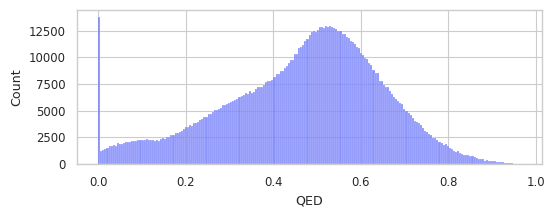

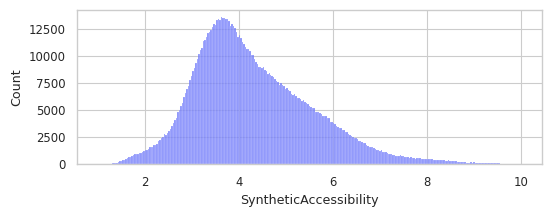

In [9]:
gems_props = torch.load('/auto/plzen1/home/romanb/msvn_A/msvn_A_H1000_K1_N2000000_mol_props.pt', map_location=torch.device('cpu')).numpy()
gems_props = gems_props[idx_gems]
print(gems_props.shape)

for i, p in enumerate(mol_calc.prop_names):
    df[p] = df_lib[p].tolist() + mol_calc.denormalize_prop(gems_props[:, i], p).tolist()
del gems_props

# TODO: clip everything based on the constructor min max values
init_plotting()
for c in ['QED', 'SyntheticAccessibility']:
    df[c] = np.clip(df[c], mol_calc.min_maxs[c]['min'], mol_calc.min_maxs[c]['max'])
    sns.histplot(df[c])
    plt.show()

### Load DreaMS F probability predictions

<Axes: ylabel='Count'>

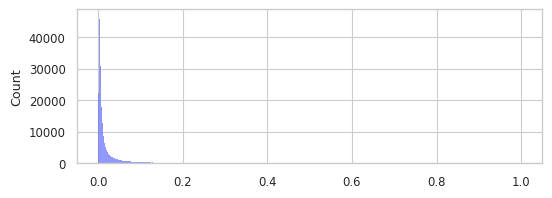

In [10]:
gems_f = torch.load('/auto/plzen1/home/romanb/msvn_A/msvn_A_H1000_K1_N2000000_f_probabilities.pt', map_location=torch.device('cpu')).numpy()
gems_f = gems_f[idx_gems, 0]
df['F probability'] = df_lib['FORMULA'].apply(lambda f: int('F' in mu.formula_to_dict(f))).tolist() + gems_f.tolist()
df['0.75 < F probability < 1.0'] = df['F probability'].apply(lambda p: 0.75 < p < 1)
sns.histplot(gems_f)

### Process MassIVE species metadata

In [11]:
topk_species = df['SPECIES'].value_counts()[:7].index
df['SPECIES TOPK'] = df['SPECIES'].apply(lambda s: s if s in topk_species else 'other')
df['SPECIES TOPK'].value_counts()

human            311061
mice             222262
other            221137
environmental    152633
                  72759
alternaria        59220
chemicals         19053
papio             14634
Name: SPECIES TOPK, dtype: int64

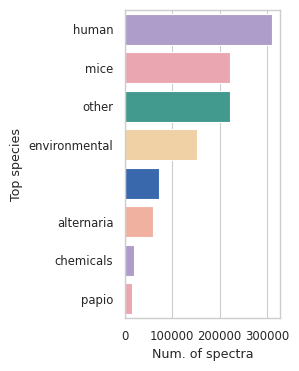

In [12]:
init_plotting(figsize=(2, 4))
topk_species_vc = df['SPECIES TOPK'].value_counts()
sns.barplot(x=topk_species_vc, y=topk_species_vc.index, palette=[palette[4], palette[2], palette[1], palette[3], palette[0], palette[5]], alpha=1)
plt.xlabel('Num. of spectra')
plt.ylabel('Top species')
save_fig('dreams_species_topk.pdf')
plt.show()

In [13]:
embs_lib = np.stack(df_lib['DreaMS'].values)
embs = np.concatenate([embs_lib, embs_gems])
embs.shape, embs_lib.shape, embs_gems.shape

((1072759, 1024), (72759, 1024), (1000000, 1024))

# Atlas construction

### k-NN graph construction

In [15]:
pynn_graph = pynndescent.PyNNDescentTransformer(
    metric='cosine', n_neighbors=3, search_epsilon=0.25, verbose=True
).fit_transform(embs)
knn = du.CSRKNN(pynn_graph)

Sun Mar 31 21:01:12 2024 Creating index
Sun Mar 31 21:01:13 2024 Building RP forest with 32 trees
Sun Mar 31 21:02:09 2024 NN descent for 20 iterations
	 1  /  20
	 2  /  20
	 3  /  20
	 4  /  20
	 5  /  20
	Stopping threshold met -- exiting after 5 iterations
Sun Mar 31 21:03:04 2024 Constructing neighbor matrix
Sun Mar 31 21:03:04 2024 Compressing index
Sun Mar 31 21:03:35 2024 Worst tree score: 0.29640488
Sun Mar 31 21:03:35 2024 Mean tree score: 0.29960262
Sun Mar 31 21:03:35 2024 Best tree score: 0.30314544
Sun Mar 31 21:03:43 2024 Forward diversification reduced edges from 4291036 to 3046576
Sun Mar 31 21:03:48 2024 Reverse diversification reduced edges from 3046576 to 3046576


/storage/brno2/home/romanb/software/miniconda3/envs/msml39/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Sun Mar 31 21:03:50 2024 Degree pruning reduced edges from 2714570 to 2703863
Sun Mar 31 21:03:50 2024 Resorting data and graph based on tree order
Sun Mar 31 21:04:15 2024 Building and compiling search function


In [16]:
knn_graph_edges = knn.to_edge_list()

### Compute novelty scores (i.e. minimum distance to spectral library entry)

In [17]:
# annoy_lib = AnnoyIndex(embs_lib.shape[1], metric='angular')
# for i, v in tqdm(enumerate(embs_lib), desc='Adding DreaMS to annoy index', total=embs_lib.shape[0]):
#     annoy_lib.add_item(i, v)
# annoy_lib.build(10)

# k = 3
# novelty_scores = np.ones(len(embs))
# for i in tqdm(range(len(embs)), desc='Computing novelty scores'):
#     if i < len(df_lib):
#         for j in annoy_lib.get_nns_by_item(i, k + 1)[1:]:
#             cos_dist = cosine_distance(embs[i], embs[j])
#             if cos_dist < novelty_scores[i]:
#                 novelty_scores[i] = cos_dist
#     else:
#         for j in annoy_lib.get_nns_by_vector(embs[i], k + 1):
#             cos_dist = cosine_distance(embs[i], embs[j])
#             if cos_dist < novelty_scores[i]:
#                 novelty_scores[i] = cos_dist
# df['Novelty score'] = novelty_scores
# sns.histplot(novelty_scores[:len(df_lib)])
# sns.histplot(novelty_scores[len(df_lib):])

In [24]:
# df.to_pickle(out_dir / 'atlas.pkl')
df = pd.read_pickle(out_dir / 'atlas.pkl')
df

,DATASET,SMILES,FORMULA,NAME,PRECURSOR M/Z,MSV ID,FILE NAME,SPECIES,FORMULA TYPE,AtomicLogP,...,FractionCSP3,QED,SyntheticAccessibility,BertzComplexity,F probability,0.75 < F probability < 1.0,SPECIES TOPK,Novelty score,LSH,Num. spectra with same LSH
0,MoNA and NIST20,Br.CN1[C@@H]2C[C@@H](OC(=O)[C@H](CO)c3ccccc3)C...,C17H22BrNO4,0,304.154000,,,,Compound with halogens,1.496000,...,0.588235,0.629883,4.832235,550.971612,0.000000,False,,0.268901,NaN,1
1,MoNA and NIST20,Br.COC(=O)C1=CCCN(C)C1,C8H14BrNO2,1,236.028061,,,,Compound with halogens,0.999200,...,0.625000,0.635899,2.787156,191.496882,0.000000,False,,0.353029,NaN,1
2,MoNA and NIST20,Br.COC(=O)C1=CCCN(C)C1,C8H14BrNO2,2,273.983948,,,,Compound with halogens,0.999200,...,0.625000,0.635899,2.787156,191.496882,0.000000,False,,0.205349,NaN,1
3,MoNA and NIST20,Br.COC(=O)C1=CCCN(C)C1,C8H14BrNO2,3,253.054611,,,,Compound with halogens,0.999200,...,0.625000,0.635899,2.787156,191.496882,0.000000,False,,0.174226,NaN,1
4,MoNA and NIST20,Br.COC(=O)C1=CCCN(C)C1,C8H14BrNO2,4,258.010010,,,,Compound with halogens,0.999200,...,0.625000,0.635899,2.787156,191.496882,0.000000,False,,0.274093,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072754,GeMS,H,,MSV000082869_Cntrl_J4_R-C6,207.158737,MSV000082869,Cntrl_J4_R-C6,Human,No formula,2.334758,...,0.629621,0.592912,3.689634,227.039642,0.002850,False,Human,0.467562,7.279967e+17,1
1072755,GeMS,H,,MSV000088021_KB_2020_75,316.175751,MSV000088021,KB_2020_75,Environmental,No formula,1.626321,...,0.755154,0.561652,6.346441,608.079773,0.003950,False,Environmental,0.515050,3.513353e+18,1
1072756,GeMS,H,,MSV000089285_99_MT_PB,349.200836,MSV000089285,99_MT_PB,Environmental,No formula,2.454302,...,0.690879,0.520660,6.640520,735.028625,0.069194,False,Environmental,0.457779,5.982888e+18,1
1072757,GeMS,H,,MSV000086415_16879494,278.105835,MSV000086415,16879494,Human,No formula,0.130604,...,0.767069,0.453555,4.480249,355.553833,0.030286,False,Human,0.570586,4.954584e+18,1


In [14]:
# init_plotting(figsize=(20, 20))
pairwise_sims = cosine_similarity(species_embs, species_embs)
# sns.heatmap(pairwise_sims, linewidth=0.5, annot=True, xticklabels=selected_species, yticklabels=selected_species)
# save_fig('dreams_species_similarity_matrix.pdf')
# plt.show()

### Construct k-NN graph

In [18]:
pynn_graph = pynndescent.PyNNDescentTransformer(
    metric='cosine', n_neighbors=3, verbose=True
).fit_transform(embs)
knn = du.CSRKNN(pynn_graph)
knn_graph_edges = knn.to_edge_list(one_minus_weights=True)

Sun Mar 31 21:04:27 2024 Creating index
Sun Mar 31 21:04:39 2024 Building RP forest with 32 trees
Sun Mar 31 21:05:21 2024 NN descent for 20 iterations
	 1  /  20
	 2  /  20
	 3  /  20
	 4  /  20
	 5  /  20
	Stopping threshold met -- exiting after 5 iterations
Sun Mar 31 21:06:04 2024 Constructing neighbor matrix
Sun Mar 31 21:06:04 2024 Compressing index
Sun Mar 31 21:06:31 2024 Worst tree score: 0.29644496
Sun Mar 31 21:06:31 2024 Mean tree score: 0.29909010
Sun Mar 31 21:06:31 2024 Best tree score: 0.30260944
Sun Mar 31 21:06:37 2024 Forward diversification reduced edges from 4291036 to 3046636
Sun Mar 31 21:06:37 2024 Reverse diversification reduced edges from 3046636 to 3046636


/storage/brno2/home/romanb/software/miniconda3/envs/msml39/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Sun Mar 31 21:06:37 2024 Degree pruning reduced edges from 2714456 to 2703675
Sun Mar 31 21:06:37 2024 Resorting data and graph based on tree order
Sun Mar 31 21:06:39 2024 Building and compiling search function


### Plot TMAP

In [19]:
cfg = tm.LayoutConfiguration()
cfg.node_size = 1 / 47
x, y, s, t, _ = tm.layout_from_edge_list(len(embs), knn_graph_edges, config=cfg)
x, y = np.array(x), np.array(y)

In [20]:
df['SPECIES TOPK'] = df['SPECIES TOPK'].replace('', 'other')

<Axes: >

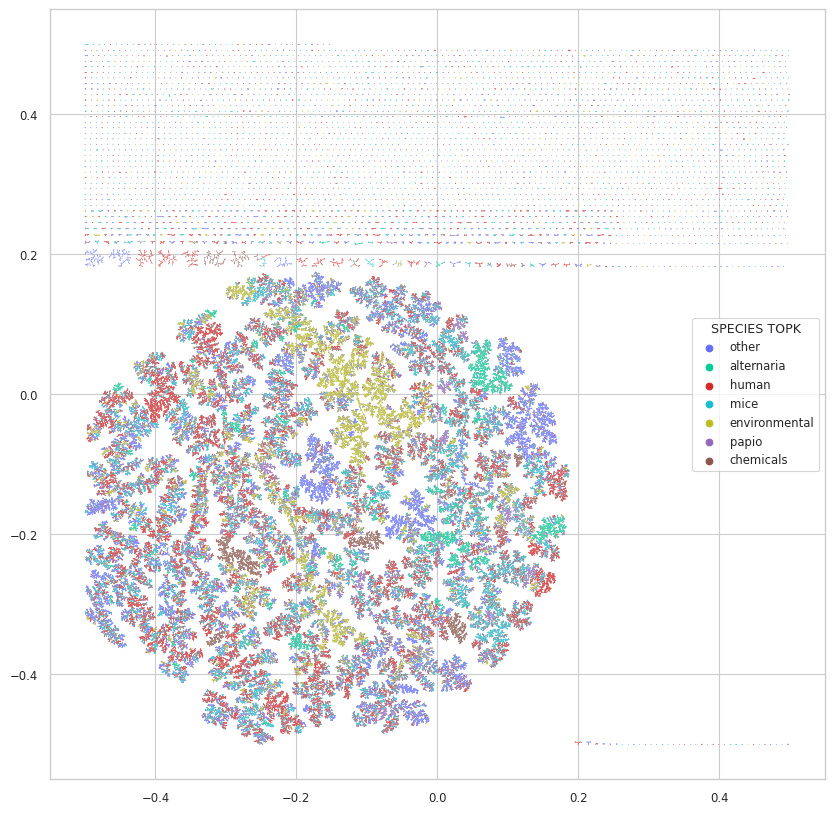

In [21]:
init_plotting(figsize=(10, 10))
sns.scatterplot(x=x, y=y, s=0.1, hue=df['SPECIES TOPK'])

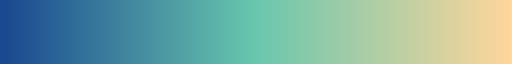

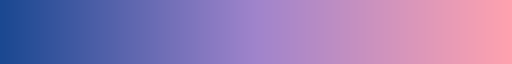

In [22]:
# from coloraide import Color
# def adjust_hex_as_hsv(hex_color, s_factor=1.2, v_factor=1.2, s_value=None, v_value=None):
#     c_hsv = Color(hex_color).convert('hsv').to_dict()['coords']
#     if v_value is None or s_value is None:
#         if s_value is not None:
#             c_hsv[1] = s_value
#         if v_value is not None:
#             c_hsv[2] = v_value
#     else:
#         c_hsv[1] = min(c_hsv[1] * s_factor, 1)
#         c_hsv[2] = min(c_hsv[2] * v_factor, 1)

colors = get_nature_hex_colors() + ['#FEA992', '#AB8D8B', '#A8A9AB']
palette1 = sns.blend_palette(['#1A4891', '#69C7AE', '#FFD69B'], as_cmap=True)
display(palette1)
palette2 = sns.blend_palette(['#1A4891', '#A084CC', '#FFA2AF'], as_cmap=True)
display(palette2)

In [24]:
species_colors = [colors[i] for i in [5, 6, 7, 3, 1, 0, 11]]
sns.blend_palette(species_colors, n_colors=len(species_colors))

[(0.996078431372549, 0.6627450980392157, 0.5725490196078431),
 (0.6744175317185697, 0.5542329873125721, 0.5454209919261822),
 (0.6588235294117647, 0.6627450980392157, 0.6705882352941176),
 (0.9751326412918108, 0.8254671280276816, 0.6000461361014994),
 (0.20392156862745103, 0.6588235294117647, 0.6039215686274509),
 (0.15903114186851267, 0.3926643598615917, 0.7446828143021912),
 (1.0, 0.43529411764705883, 0.3803921568627451)]

In [25]:
sns.blend_palette(colors, n_colors=len(colors))

[(0.14901960784313725, 0.39215686274509803, 0.7490196078431373),
 (0.20327566320645907, 0.655686274509804, 0.6056286043829295),
 (0.9468050749711652, 0.6128719723183391, 0.6613610149942329),
 (0.9836216839677047, 0.8198385236447521, 0.6022145328719722),
 (0.6809227220299887, 0.5849288735101885, 0.817670126874279),
 (0.9948327566320649, 0.6624375240292196, 0.5735178777393308),
 (0.6756939638600536, 0.5546635909265667, 0.5455286428296808),
 (0.6521491733948481, 0.6527335640138408, 0.6680046136101498),
 (0.42140715109573285, 0.30806612841214986, 0.5801614763552482),
 (0.777331795463284, 0.9367474048442908, 0.8117954632833525),
 (0.0061207227989220625, 0.8088581314878891, 0.8195463283352556),
 (0.9998615916955017, 0.44332179930795845, 0.3871741637831603),
 (0.9884198385236445, 0.6601614763552479, 0.5719031141868511),
 (0.6704498269896193, 0.5542329873125722, 0.5465743944636678),
 (0.6588235294117647, 0.6627450980392157, 0.6705882352941176)]

Plotting pieces:   0%|          | 0/5 [00:00<?, ?it/s]

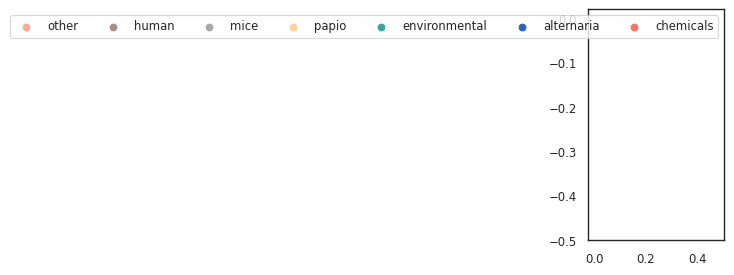

Plotting pieces:  20%|██        | 1/5 [00:20<01:22, 20.62s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


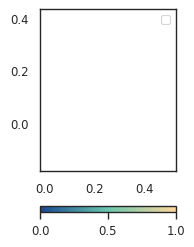

Plotting pieces:  40%|████      | 2/5 [00:22<00:29,  9.68s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


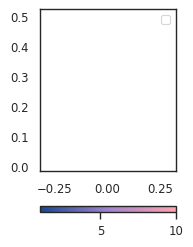

Plotting pieces:  60%|██████    | 3/5 [00:24<00:12,  6.12s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


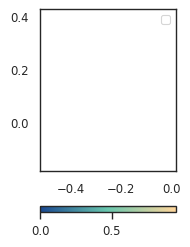

Plotting pieces:  80%|████████  | 4/5 [00:26<00:04,  4.49s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


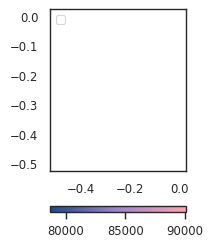

Plotting pieces: 100%|██████████| 5/5 [00:29<00:00,  5.94s/it]


In [32]:
def get_piece(x, y, n_pieces=5):
    angle = math.atan2(x, -y)
    if angle < 0:
        angle += 2 * math.pi
    piece_angle = 2 * math.pi / n_pieces
    return math.floor(angle / piece_angle)

# Selecting only the largest blob
blob_mask = (x < 0.18) & (y < 0.18)
x_scaled = x[blob_mask]
y_scaled = y[blob_mask]
df_z = df[blob_mask]

# Min-max scaling and centering around 0
x_scaled = (x_scaled - x_scaled.min()) / (x_scaled.max() - x_scaled.min())
y_scaled = (y_scaled - y_scaled.min()) / (y_scaled.max() - y_scaled.min())
x_scaled -= 0.5
y_scaled -= 0.5

cols = ['SPECIES TOPK', 'F probability', 'SyntheticAccessibility', 'QED', 'MSV ID number']
n_pieces = len(cols)
piece_numbers = np.array([get_piece(x1, y1, n_pieces) for x1, y1 in zip(x_scaled, y_scaled)])
# init_plotting(figsize=(10, 10), style='white')
s = 0.2
for i, c in enumerate(tqdm(cols, desc='Plotting pieces')):
    piece_mask = piece_numbers == i
    if c == 'SPECIES TOPK':
        palette = species_colors
    else:
        palette = palette1 if i in [1, 3] else palette2
    norm = matplotlib.colors.LogNorm() if c in ['Num. spectra with same LSH'] else None

    init_plotting(figsize=(1.75, 3), style='white')
    if c not in ['SPECIES TOPK']:
        points = plt.scatter(x=x_scaled[piece_mask], y=y_scaled[piece_mask], c=df_z[c][piece_mask], s=s, alpha=1, cmap=palette) #set style options
        points.set_visible(False)
        plt.colorbar(points, orientation='horizontal')
        plt.legend()

        # plt.scatter(x=x_scaled[piece_mask], y=y_scaled[piece_mask], c=df_z[c][piece_mask], s=s, alpha=1, linewidth=0, norm=norm, cmap=palette)
        # if c == 'MSV ID number':
        #     hue = df_z[c][piece_mask]
        #     lib_mask = hue.isna()
        #     plt.scatter(x=x_scaled[piece_mask][lib_mask], y=y_scaled[piece_mask][lib_mask], s=s, alpha=1, linewidth=0, color=colors[3])
    else:
        hue = df_z[c][piece_mask].replace('', 'Other')

        # sns.scatterplot(x=x_scaled[piece_mask], y=y_scaled[piece_mask], hue=hue, palette=palette, s=s, alpha=1, linewidth=0, norm=norm)

        sns.scatterplot(x=x_scaled[piece_mask], y=y_scaled[piece_mask], hue=hue, palette=palette, s=0, alpha=1, linewidth=0, norm=norm)
        plt.legend(ncol=hue.nunique())

    save_fig(f'dreams_atlas_piece_{c.replace(" ", "_")}.svg', dir=Path('/storage/plzen1/home/romanb/DreaMS_Atlas'))
    plt.show()

# plt.axis('off')
# save_fig(f'dreams_atlas_pieces.png', dpi=450, dir=Path('/storage/plzen1/home/romanb/DreaMS_Atlas'))
### plt.scatter([x_scaled[30930]], [y_scaled[30930]], color='red', s=20)
# plt.show()

In [60]:
fae_c_labels, fae_c_data, fae_c_is_cat, fae_c_titles, fae_c_cmaps = [], [], [], [], []
max_legend_labels, min_legend_labels = [], []
for c in ['DATASET', 'FORMULA TYPE', 'SPECIES TOPK', '0.75 < F probability < 1.0']:
    l, d = Faerun.create_categories(df[c].tolist())
    fae_c_data.append(d)
    fae_c_labels.append(l)
    fae_c_is_cat.append(True)
    fae_c_titles.append(c)
    if c == 'DATASET' or c == '0.75 < F probability < 1.0':
        fae_c_cmaps.append(ListedColormap(['#5F6062', '#FFA500']))
    else:
        fae_c_cmaps.append('tab10')
    max_legend_labels.append(None)
    min_legend_labels.append(None)
for c in ['PRECURSOR M/Z', 'F probability', 'Novelty score'] + prop_calc.prop_names:
    fae_c_data.append(df[c].tolist())
    fae_c_is_cat.append(False)
    fae_c_titles.append(c)
    fae_c_cmaps.append('viridis')
    max_legend_labels.append(str(max(df[c])))
    min_legend_labels.append(str(min(df[c])))

In [61]:
s_thld, t_thld = [], []
for i in tqdm(range(len(s))):
    if cosine_distance(embs[s[i]], embs[t[i]]) < 0.1:
        s_thld.append(s[i])
        t_thld.append(t[i])
len(s_thld), len(s)

100%|██████████████████████████████████████████████████| 1067206/1067206 [00:36<00:00, 29396.11it/s]


(598077, 1067206)

In [62]:
faerun = Faerun(view="front", coords=False)
faerun.add_scatter(
    "dreams_atlas_scatter",
    {"x": x, "y": y, "c": fae_c_data, "labels": df['SMILES'].astype(str) + '__' + df.index.astype(str).tolist()},
    shader="smoothCircle",
    colormap=fae_c_cmaps,
    point_scale=0.4,
    max_point_size=20,
    has_legend=True,
    categorical=fae_c_is_cat,
    legend_labels=fae_c_labels,
    series_title=fae_c_titles,
    max_legend_label=max_legend_labels,
    min_legend_label=min_legend_labels,
    selected_labels=["SMILES", "Index"]
)
faerun.add_tree(
    "dreams_atlas_tree",
    {"from": s_thld, "to": t_thld},
    point_helper="dreams_atlas_scatter",
    color="#666666",
)

out_html_name = 'dreams_atlas_v0.4'
out_dir = '/storage/plzen1/home/romanb/tmaps'
faerun.plot(file_name=out_html_name, path=out_dir, template="smiles")

/storage/plzen1/home/romanb/tmaps/dreams_atlas_v0.4.html